In [2]:
!unzip -q Composer_Dataset.zip

In [3]:
!pip install pretty_midi
!pip install mido librosa
import pretty_midi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 63.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 4.7 MB/s eta 0:00:00
  Created wheel for pretty_midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592286 sha256=b39333a5bcde5f0d10710a1dd7ddc7288e1f2a62d7709abede1a7482192ed906
  Stored in directory: /root/.cache/pip/wheels/e6/95/ac/15ceaeb2823b04d8e638fd1495357adb8d26c00ccac9d7782e
Successfully built pretty_midi


In [21]:
import os
import numpy as np
import pretty_midi
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

 ## Function to Read MIDI Files as Piano Roll

 ## get_fixed_piano_roll():
 This function reads a single MIDI file and converts it into a fixed-size piano roll matrix, which is a common input format for deep learning models like CNNs.

In [6]:
def get_fixed_piano_roll(midi_path, max_time_steps=500):
    try:
        midi = pretty_midi.PrettyMIDI(midi_path)
        roll = midi.get_piano_roll(fs=100)[:128, :]  # only 128 pitches
        if roll.shape[1] < max_time_steps:
            pad = max_time_steps - roll.shape[1]
            roll = np.pad(roll, ((0, 0), (0, pad)), mode='constant')
        else:
            roll = roll[:, :max_time_steps]
        return roll
    except Exception as e:
        print(f"Skipped {midi_path}: {e}")
        return None

## process_and_save_all()
This function performs the following steps
- Read all .mid/.midi files in folders (organized by composer),

- Convert them into fixed-size piano roll matrices (via get_fixed_piano_roll()),

- Save each piano roll to disk as a .npy file,

- Create a CSV index file listing:

- the .npy file path

- the label (composer name)



In [7]:
def process_and_save_all(mid_root, save_dir, csv_path):
    os.makedirs(save_dir, exist_ok=True)
    rows = []
    for composer in sorted(os.listdir(mid_root)):
        comp_dir = os.path.join(mid_root, composer)
        if not os.path.isdir(comp_dir): continue
        for fname in os.listdir(comp_dir):
            if not fname.lower().endswith(('.mid', '.midi')): continue
            full_path = os.path.join(comp_dir, fname)
            piano_roll = get_fixed_piano_roll(full_path)
            if piano_roll is not None:
                save_name = f"{composer}_{fname.replace('.mid','').replace('.midi','')}.npy"
                save_path = os.path.join(save_dir, save_name)
                np.save(save_path, piano_roll)
                rows.append([save_path, composer])
    df = pd.DataFrame(rows, columns=['file_path', 'label'])
    df.to_csv(csv_path, index=False)
    print(f"Saved {len(df)} files to {save_dir} and index to {csv_path}")

In [8]:
import pandas as pd
process_and_save_all(
    mid_root="Composer_Dataset/NN_midi_files_extended/train",
    save_dir="saved_pianorolls/train",
    csv_path="saved_pianorolls/train_index.csv"
)

/usr/local/lib/python3.11/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Saved 369 files to saved_pianorolls/train and index to saved_pianorolls/train_index.csv


In [9]:

df = pd.read_csv("saved_pianorolls/train_index.csv")
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=0)
unique_labels = sorted(df['label'].unique())
label_map = {label: idx for idx, label in enumerate(unique_labels)}
num_classes = len(label_map)

df['label_idx'] = df['label'].map(label_map)

# Load piano roll data
X = []
y = []
for _, row in df.iterrows():
    X.append(np.load(row['file_path']))
    y.append(row['label_idx'])

X = np.array(X)
y = np.array(y)

# Reshape for CNN: add channel dimension
X = X[..., np.newaxis]  # shape becomes (samples, 128, 500, 1)
#X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)

# Step 1: First split train+val and test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)

# Step 2: Now split X_temp into train and val
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=0)
# Now: 60% train, 20% val, 20% test

In [10]:
def load_data(df):
    X = []
    y = []
    label_map = {label: i for i, label in enumerate(df['label'].unique())}
    for _, row in df.iterrows():
        X.append(np.load(row['file_path']))
        y.append(label_map[row['label']])
    return np.array(X), np.array(y), label_map

In [22]:

model = Sequential([
    Input(shape=(128, 500, 1)),  # use Input layer instead of input_shape in Conv2D
    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

In [23]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=32)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    callbacks=[early_stop, checkpoint]
)

Epoch 1/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.1707 - loss: 2.9371

7/7 ━━━━━━━━━━━━━━━━━━━━ 66s 8s/step - accuracy: 0.1743 - loss: 2.9403 - val_accuracy: 0.1622 - val_loss: 19.0147
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.3514 - loss: 2.0856

7/7 ━━━━━━━━━━━━━━━━━━━━ 62s 6s/step - accuracy: 0.3606 - loss: 2.0612 - val_accuracy: 0.1216 - val_loss: 8.4430
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.4629 - loss: 1.4417

7/7 ━━━━━━━━━━━━━━━━━━━━ 86s 7s/step - accuracy: 0.4661 - loss: 1.4425 - val_accuracy: 0.1486 - val_loss: 5.4143
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.5542 - loss: 1.2900

7/7 ━━━━━━━━━━━━━━━━━━━━ 41s 6s/step - accuracy: 0.5568 - loss: 1.2883 - val_accuracy: 0.1216 - val_loss: 3.3776
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.6302 - loss: 1.0718

7/7 ━━━━━━━━━━━━━━━━━━━━ 90s 7s/step - accuracy: 0.6346 - loss: 1.0638 - val_accuracy: 0.1757 - val_loss: 2.5658
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.6889 - loss: 0.9629

7/7 ━━━━━━━━━━━━━━━━━━━━ 78s 7s/step - accuracy: 0.6927 - loss: 0.9567 - val_accuracy: 0.2297 - val_loss: 2.2873
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7736 - loss: 0.7833

7/7 ━━━━━━━━━━━━━━━━━━━━ 43s 6s/step - accuracy: 0.7753 - loss: 0.7788 - val_accuracy: 0.1757 - val_loss: 2.0869
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8082 - loss: 0.6849

7/7 ━━━━━━━━━━━━━━━━━━━━ 86s 7s/step - accuracy: 0.8096 - loss: 0.6799 - val_accuracy: 0.1757 - val_loss: 2.0451
Epoch 9/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7641 - loss: 0.6867

7/7 ━━━━━━━━━━━━━━━━━━━━ 88s 8s/step - accuracy: 0.7710 - loss: 0.6762 - val_accuracy: 0.1757 - val_loss: 2.0395
Epoch 10/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8877 - loss: 0.5036

7/7 ━━━━━━━━━━━━━━━━━━━━ 71s 6s/step - accuracy: 0.8888 - loss: 0.5003 - val_accuracy: 0.1757 - val_loss: 1.9918
Epoch 11/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9123 - loss: 0.3583

7/7 ━━━━━━━━━━━━━━━━━━━━ 82s 6s/step - accuracy: 0.9114 - loss: 0.3612 - val_accuracy: 0.1486 - val_loss: 1.9620
Epoch 12/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9490 - loss: 0.2602

7/7 ━━━━━━━━━━━━━━━━━━━━ 85s 7s/step - accuracy: 0.9474 - loss: 0.2647 - val_accuracy: 0.1892 - val_loss: 1.9518
Epoch 13/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9537 - loss: 0.2711

7/7 ━━━━━━━━━━━━━━━━━━━━ 42s 6s/step - accuracy: 0.9527 - loss: 0.2736 - val_accuracy: 0.2297 - val_loss: 1.9436
Epoch 14/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9599 - loss: 0.2402

7/7 ━━━━━━━━━━━━━━━━━━━━ 83s 6s/step - accuracy: 0.9593 - loss: 0.2410 - val_accuracy: 0.2162 - val_loss: 1.9428
Epoch 15/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 78s 6s/step - accuracy: 0.9392 - loss: 0.2830 - val_accuracy: 0.2162 - val_loss: 1.9688
Epoch 16/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 41s 6s/step - accuracy: 0.9644 - loss: 0.2028 - val_accuracy: 0.2162 - val_loss: 1.9764
Epoch 17/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 40s 6s/step - accuracy: 0.9615 - loss: 0.2139 - val_accuracy: 0.2297 - val_loss: 1.9629
Epoch 18/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 40s 5s/step - accuracy: 0.9615 - loss: 0.1469 - val_accuracy: 0.2297 - val_loss: 1.9790
Epoch 19/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 51s 7s/step - accuracy: 0.9711 - loss: 0.1439 - val_accuracy: 0.2297 - val_loss: 2.0090


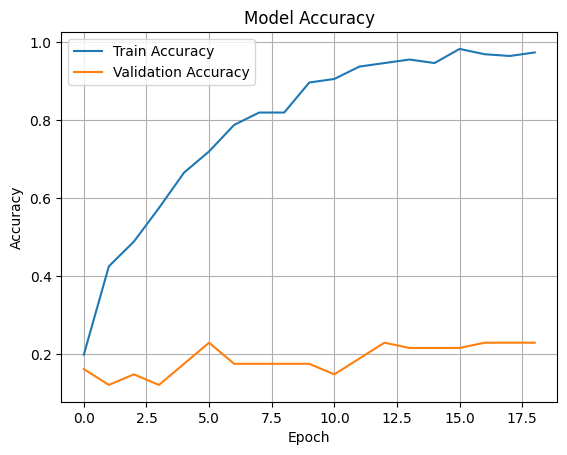

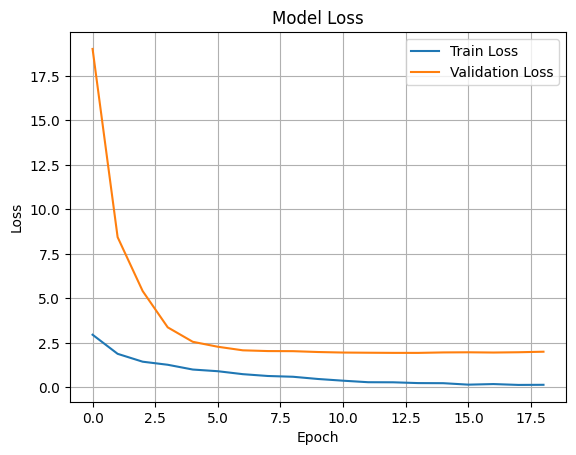

In [24]:
import matplotlib.pyplot as plt

# Accuracy
plt.figure()
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [25]:
from sklearn.metrics import classification_report, confusion_matrix
y_pred = np.argmax(model.predict(X_test), axis=1)
print(classification_report(y_test, y_pred))

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 606ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.50      0.25      0.33         8
           2       0.67      0.89      0.76         9
           3       0.27      0.38      0.32         8
           4       0.50      0.25      0.33         8
           5       0.67      0.22      0.33         9
           6       0.27      0.38      0.32         8
           7       0.40      0.50      0.44         8
           8       0.21      0.50      0.30         8

    accuracy                           0.38        74
   macro avg       0.39      0.37      0.35        74
weighted avg       0.40      0.38      0.35        74



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 553ms/step


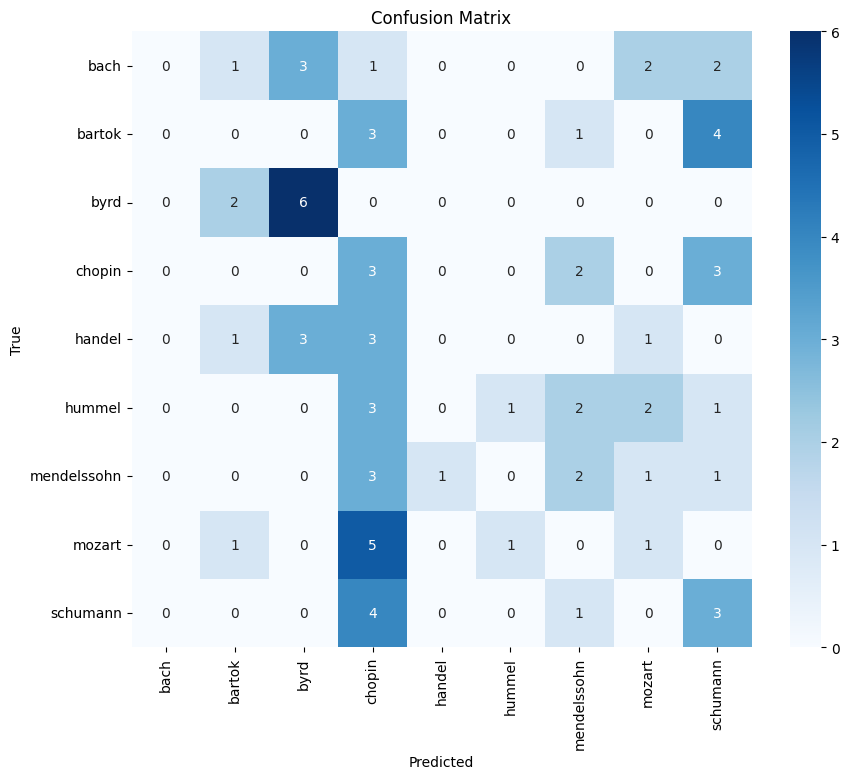

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predict and evaluate
y_pred = np.argmax(model.predict(X_val), axis=1)  # Or X_test if defined
cm = confusion_matrix(y_val, y_pred)

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=unique_labels, yticklabels=unique_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [27]:
y_pred_indices = np.argmax(model.predict(X_val), axis=1)
# Reverse map from label index to composer name
index_to_label = {v: k for k, v in label_map.items()}

# Get predicted and true composer names
y_pred_composers = [index_to_label[i] for i in y_pred_indices]
y_true_composers = [index_to_label[i] for i in y_val]
# Print a sample of predicted vs. true labels
print("Sample Predictions:")
for i in range(20):  # Adjust range for more
    print(f"True: {y_true_composers[i]:<10} | Predicted: {y_pred_composers[i]}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 554ms/step
Sample Predictions:
True: mendelssohn | Predicted: mendelssohn
True: handel     | Predicted: mozart
True: mozart     | Predicted: chopin
True: bach       | Predicted: schumann
True: chopin     | Predicted: schumann
True: handel     | Predicted: chopin
True: bach       | Predicted: schumann
True: hummel     | Predicted: hummel
True: handel     | Predicted: chopin
True: byrd       | Predicted: byrd
True: schumann   | Predicted: schumann
True: mozart     | Predicted: chopin
True: mendelssohn | Predicted: handel
True: byrd       | Predicted: byrd
True: handel     | Predicted: bartok
True: bach       | Predicted: byrd
True: bartok     | Predicted: schumann
True: mozart     | Predicted: chopin
True: chopin     | Predicted: mendelssohn
True: bach       | Predicted: byrd
